In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score

from sklearn.feature_selection import SelectKBest, chi2

#### Download data

In [32]:
dataset = datasets.load_diabetes(return_X_y = False)
cols = dataset.feature_names

In [33]:
X, y = datasets.load_diabetes(return_X_y = True)
X = pd.DataFrame(X, columns = cols)
y = pd.Series(y, name = 'target')

In [34]:
def print_dataset_descr(dataset):
    
    try:
        
        import pprint
        pp = pprint.PrettyPrinter()
        pp.pprint(dataset['DESCR'])
        
    except NameError:
        
        print('Cannot import pprint')

In [35]:
print_dataset_descr(dataset)

('.. _diabetes_dataset:\n'
 '\n'
 'Diabetes dataset\n'
 '----------------\n'
 '\n'
 'Ten baseline variables, age, sex, body mass index, average blood\n'
 'pressure, and six blood serum measurements were obtained for each of n =\n'
 '442 diabetes patients, as well as the response of interest, a\n'
 'quantitative measure of disease progression one year after baseline.\n'
 '\n'
 '**Data Set Characteristics:**\n'
 '\n'
 '  :Number of Instances: 442\n'
 '\n'
 '  :Number of Attributes: First 10 columns are numeric predictive values\n'
 '\n'
 '  :Target: Column 11 is a quantitative measure of disease progression one '
 'year after baseline\n'
 '\n'
 '  :Attribute Information:\n'
 '      - Age\n'
 '      - Sex\n'
 '      - Body mass index\n'
 '      - Average blood pressure\n'
 '      - S1\n'
 '      - S2\n'
 '      - S3\n'
 '      - S4\n'
 '      - S5\n'
 '      - S6\n'
 '\n'
 'Note: Each of these 10 feature variables have been mean centered and scaled '
 'by the standard deviation times `n_s

### EDA

In [36]:
data = pd.concat([X, y], axis = 1)

#### Количество пропусков и дубликатов

In [37]:
print('Количество пропусков в данных')
print()
data.isnull().sum()

Количество пропусков в данных



age       0
sex       0
bmi       0
bp        0
s1        0
s2        0
s3        0
s4        0
s5        0
s6        0
target    0
dtype: int64

In [38]:
print('Количество дубликатов: {0}'.format(data.duplicated().sum()))

Количество дубликатов: 0


#### Наблюдение

Пропусков и дубликатов нет, датасет, видимо, очищен до нас, поэтому можем двигаться дальше.

### Графики

In [39]:
import seaborn as sns

#### Посмотрим на распределение целевой переменной

Видим, что у целевой переменной есть ярковыраженная смещенность или positive skew. Таким образом, мат.ожидание целевой переменной будет больше значения медианы целевой переменной. 

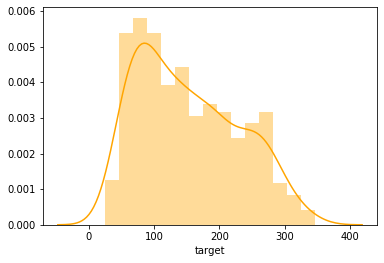

In [40]:
#plt.hist(data['target'], bins = 15, histtype = 'bar')
sns.distplot(data['target'], bins = 15, color = 'orange')
plt.show()

#### Наблюдение

Из данных можно выделить примерно три группы на глаз: группа со значением target от 50 до 120 примерно, потом от 120 до 275 и третья группа - 275+. При желании можно потом попробовать решить задачу классификации по этим, перекодировав переменные соответствующим образом по категориям.

#### Есть ли стат выбросы в target?

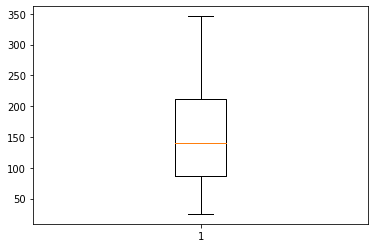

In [41]:
plt.boxplot(data['target'])
plt.show()

#### Наблюдение

Визуально стат выбросов в целевой переменной нет.

#### Выбросы в признаках

Выбросы есть сразу в нескольких признаках, например, в bmi, s1, s3 и т.д. От таких значений можно избавиться и качество нашей модели должно улучшиться.

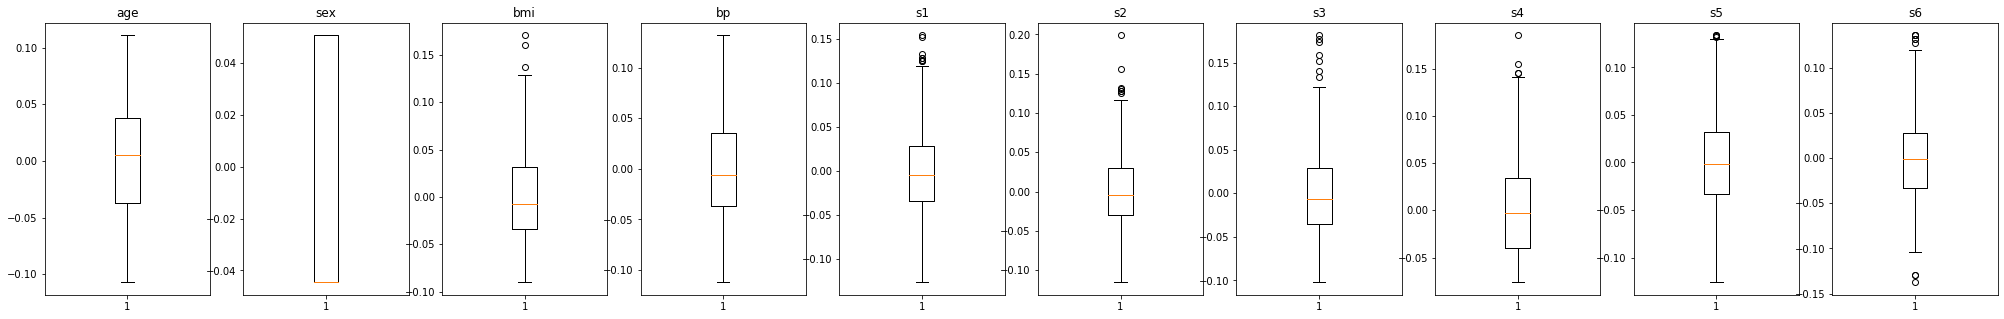

In [116]:
cols = list(X.columns)

fig, (ax) = plt.subplots(1, 10)
fig.set_figwidth(35)
fig.set_figheight(5)

for item in list(zip(ax, cols)):
    
    item[0].boxplot(data[item[1]])
    item[0].set_title(item[1])
plt.show()

#### Выбросы в целевой переменной

Выбросов в целевой переменной не наблюдается.

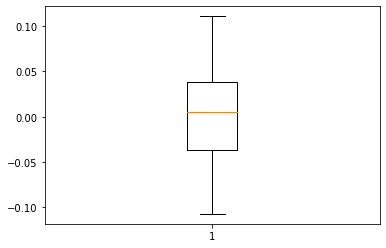

In [43]:
plt.boxplot(data['age'])
plt.show()

### Модели

In [44]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, Lasso, LinearRegression, HuberRegressor
from sklearn.model_selection import train_test_split

#### Полезные функции

In [45]:
def mape(y_true, y_pred):
    
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [46]:
def fit_predict(model, metric, X_train, X_valid, y_train, y_valid):
    
    model.fit(X_train, y_train)
    pred_valid = model.predict(X_valid)
    print('Mape result is {0}'.format(metric(y_valid, pred_valid)))

#### Отбор лучших признаков

In [47]:
#selectK = SelectKBest(score_func = chi2, k = 4)
#X = selectK.fit_transform(X, y)

#### Разбиение выборки на три группы

In [48]:
X_train, X_test, y_train, X_test = train_test_split(X, y, test_size = 0.2, random_state = 25)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2, random_state = 25)

#### Инициализация моделей

In [51]:
linreg = LinearRegression()
ridge = Ridge(random_state = 25)
lasso = Lasso(random_state = 25)
huber = HuberRegressor()

In [52]:
models = [('ridge', ridge), ('linreg', linreg), ('lasso', lasso), ('huber', huber)]

#### Модели на стандарном датасете без преобразований

In [53]:
for model in models:
    
    print('Current model is {0}'.format(model[0]))
    print()
    fit_predict(model[1], mape, X_train, X_valid, y_train, y_valid)
    reg = model[1].fit(X_train, y_train)
    pred = reg.predict(X_valid)
    print('R-2 score is {0}'.format(r2_score(y_valid, pred)))
    print()

Current model is ridge

Mape result is 42.82002841842687
R-2 score is 0.32743683028596104

Current model is linreg

Mape result is 37.275663126563394
R-2 score is 0.43552591604382573

Current model is lasso

Mape result is 43.075550596693134
R-2 score is 0.3167398514898174

Current model is huber

Mape result is 36.95826794495467
R-2 score is 0.4384219877936948



#### Наблюдения

Итак, мы видим, что лучший результат без тюнинга параметров показывает модель HuberRegressor.

#### Мысли по улучшению модели

Как можно улучшить модель?
<br>
Самый очевидный способ - заняться подгоном параметров.
<br>
Также можно вернуться к фичам и попробовать погенерировать несколько составных фич и посмотреть на результаты еще раз. 
<br>
Еще предлагаю попробовать другие метрики и посмотреть что получится на других метриках, они могут помочь понять хорошая у нас модель или нет. Проблема MSE именно в том, что это величина абсолютная, поэтому сравнить модели между собой можно - та, где меньше MSE, лучше, но общего понимания того, насколько хорошо модель предсказывает целевую переменную мы не получаем.

#### Модели с полиномиальными признаками второй степени

In [54]:
poly = PolynomialFeatures(2)
X = pd.DataFrame(poly.fit_transform(X))

In [55]:
X_train, X_test, y_train, X_test = train_test_split(X, y, test_size = 0.2, random_state = 25)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2, random_state = 25)

In [56]:
for model in models:
    
    print('Current model is {0}'.format(model[0]))
    print()
    fit_predict(model[1], mape, X_train, X_valid, y_train, y_valid)
    reg = model[1].fit(X_train, y_train)
    pred = reg.predict(X_valid)
    print('R-2 score is {0}'.format(r2_score(y_valid, pred)))
    print()

Current model is ridge

Mape result is 42.804229981601225
R-2 score is 0.3277672296176136

Current model is linreg

Mape result is 38.01444095440279
R-2 score is 0.39731382971634355

Current model is lasso

Mape result is 43.075550596693134
R-2 score is 0.3167398514898174

Current model is huber

Mape result is 35.44047195774676
R-2 score is 0.44838826682380706



#### Модель с трансформацией целевой переменной

Рассмотрим пару способов трансформации целевой переменной. 
<br>
Первый: Приведение целевой переменной к диапазону [0, 1].
<br>
Второй: Стандартизация переменной через вычитание среднего и деления на стандартное отклонение.

#### Трансформация MinMax

In [57]:
X, y = datasets.load_diabetes(return_X_y = True)
X = pd.DataFrame(X, columns = cols)
y = pd.Series(y, name = 'target')

In [58]:
X_train, X_test, y_train, X_test = train_test_split(X, y, test_size = 0.2, random_state = 25)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2, random_state = 25)

In [59]:
scaler = StandardScaler()

y_train = y_train.values.reshape(-1, 1)
y_valid = y_valid.values.reshape(-1, 1)

y_train = scaler.fit_transform(y_train)
y_valid = scaler.transform(y_valid)

In [60]:
for model in models:
    
    print('Current model is {0}'.format(model[0]))
    print()
    fit_predict(model[1], mape, X_train, X_valid, y_train, y_valid)
    reg = model[1].fit(X_train, y_train)
    pred = reg.predict(X_valid)
    print('R-2 score is {0}'.format(r2_score(y_valid, pred)))
    print()

Current model is ridge

Mape result is 121.18861316711882
R-2 score is 0.32743683028596116

Current model is linreg

Mape result is 131.48661002178324
R-2 score is 0.4355259160438263

Current model is lasso

Mape result is 100.0
R-2 score is -0.025508685563474964

Current model is huber

Mape result is 231.34295044542594
R-2 score is 0.4379089394900676



/Users/gost/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gost/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### Стандартизация

In [61]:
X, y = datasets.load_diabetes(return_X_y = True)
X = pd.DataFrame(X, columns = cols)
y = pd.Series(y, name = 'target')

In [62]:
X_train, X_test, y_train, X_test = train_test_split(X, y, test_size = 0.2, random_state = 25)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2, random_state = 25)

In [63]:
minmax = MinMaxScaler()

y_train = y_train.values.reshape(-1, 1)
y_valid = y_valid.values.reshape(-1, 1)

y_train = minmax.fit_transform(y_train)
y_valid = minmax.transform(y_valid)

In [64]:
for model in models:
    
    print('Current model is {0}'.format(model[0]))
    print()
    fit_predict(model[1], mape, X_train, X_valid, y_train, y_valid)
    reg = model[1].fit(X_train, y_train)
    pred = reg.predict(X_valid)
    print('R-2 score is {0}'.format(r2_score(y_valid, pred)))
    print()

Current model is ridge

Mape result is 65.20970292444241
R-2 score is 0.32743683028596116

Current model is linreg

Mape result is 56.45991651285753
R-2 score is 0.43552591604382607

Current model is lasso

Mape result is 84.52718521922019
R-2 score is -0.025508685563474964

Current model is huber

Mape result is 93.86333938893972
R-2 score is 0.4380681813115671



/Users/gost/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gost/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Вывод

Пока модель показывает неутешительные результаты и максимальное значение R-squared, которое удалось достигнуть - около 0.43, что означает, что с помощью нашей модели мы объяснили только около 43% вариации в целевой переменной.